# Variability in the branches

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_pilot_8c


Imports for the analysis

In [3]:
from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from pandas import DataFrame, concat
import seaborn as sb
from sklearn.manifold import MDS

from gists.models import Sentence, Tree

from analysis.utils import grouper, memoized, mpl_palette

## 2 Slice variability ~ depth

First define slice variability on a tree

In [4]:
def variabilities(sentences):
    return np.array([s1.oc_distance(s2)
                     for s1, s2 in combinations(sentences, 2)])

@memoized
def get_leaves(self):
    return [s for s in self.sentences.kept.all() if s.children.kept.count() == 0]

@memoized
def get_depth(self):
    return np.max([l.depth for l in self.leaves])

@memoized
def get_min_depth(self):
    return np.min([l.depth for l in self.leaves])

@memoized
def get_slice(self, depth):
    return [s for s in self.sentences.kept if s.depth == depth]

@memoized
def get_slice_variabilities(self, depth):
    return variabilities(self.get_slice(depth))

Tree.leaves = property(get_leaves)
Tree.depth = property(get_depth)
Tree.min_depth = property(get_min_depth)
Tree.get_slice = get_slice
Tree.get_slice_variabilities = get_slice_variabilities

Then generate our data

In [5]:
trees = Tree.objects.experiment.all()
data = []
for tree in trees:
    root_length = len(tree.root.content_words)
    for depth in range(1, tree.depth + 1):
        for v in tree.get_slice_variabilities(depth):
            data.append({'tree id': tree.id,
                         'depth': depth,
                         'root length': root_length,
                         'slice variabilities': v})
data = DataFrame(data)
root_order = data.groupby('tree id', as_index=False).mean().sort_values(\
    ['root length', 'tree id'])

In [6]:
depth_variabilities = data.groupby(['tree id', 'depth'], as_index=False).mean()

Slice variability accross all trees (each depth has a point for each tree)

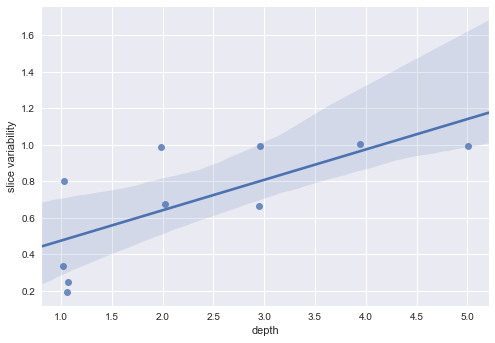

In [7]:
ax = sb.regplot('depth', 'slice variabilities', data=depth_variabilities,
                x_jitter=.1, y_jitter=.01)
ax.set_ylabel('slice variability')
if SAVE_FIGURES:
    ax.figure.savefig(FIG.format('slice-variability_depth_scatter'), dpi=300)

The same, but with averages at each depth

In [8]:
def plot_slice_variability(**kwargs):
    data = kwargs['data']
    gdata = data.groupby('depth', as_index=False)
    color = sb.color_palette()[0]
    
    x = gdata.first()['depth']
    y = gdata.mean()['slice variabilities']
    ci = gdata['slice variabilities'].aggregate({
            'ci': lambda v: v.std() * 1.96 / np.sqrt(len(v) - 1)
    })['ci']
    
    plt.plot(x, y, color=color)
    plt.fill_between(x, y - ci, y + ci, color=sb.desaturate(color, 0.2), alpha=0.2)

    return plt.gca()

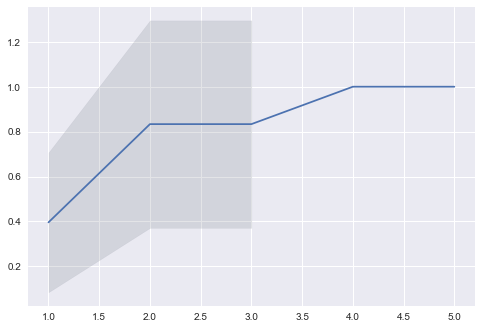

In [9]:
ax = plot_slice_variability(data=depth_variabilities)
if SAVE_FIGURES:
    ax.figure.savefig(FIG.format('slice-variability_depth_average'), dpi=300)

The same, but with detail for each tree

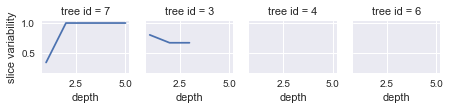

In [10]:
g = sb.FacetGrid(data=data, sharex=True, sharey=True,
                 col='tree id', col_wrap=7, size=1.5,
                 col_order=root_order['tree id'])
g.map_dataframe(plot_slice_variability)
g.set_axis_labels(x_var='depth', y_var='slice variability')
if SAVE_FIGURES:
    g.savefig(FIG.format('slice-variability_depth_per-tree'), dpi=300)

## 3 Slice MDS ~ depth

Add the multi-dimensional scaling tools

In [11]:
@memoized
def similarities_with_previous_leaves(self, depth):
    # Compute similarities matrix
    sentences = self.get_slice(depth)
    
    branches = set([s.head for s in sentences])
    all_branches = set([c for c in self.root.children.kept])
    compl_branches = all_branches.difference(branches)
    compl_leaves = [l for l in self.leaves if l.head in compl_branches]

    full_sentences = sentences + compl_leaves
    size = len(full_sentences)
    
    similarities = np.zeros((size, size))
    indices = {}
    for i, s1 in enumerate(full_sentences):
        if s1.id not in indices:
            indices[s1.id] = i
        for j, s2 in enumerate(full_sentences):
            similarities[i, j] = s1.oc_distance(s2)
    
    # Check we saw all the indices go past
    assert len(indices) == size
    
    return (similarities, indices, sentences)

@memoized
def scalings(self):
    data = []
    stresses = []
    pos = None
    branchindices = None
    for depth in range(1, self.depth + 1):
        # Compute similarities
        similarities, indices, sentences = self.similarities_with_previous_leaves(depth)
        if len(sentences) < 2:
            # There's only one branch left, we're done.
            break
        
        # Get branch indices
        old_branchindices = branchindices
        branchindices = dict((Sentence.objects.get(id=s).head.id, i)
                             for (s, i) in indices.items())
        rev_branchindices = dict((i, b) for (b, i) in branchindices.items())
        rev_indices = dict((i, s) for (s, i) in indices.items())

        # Compute scaling
        old_pos = pos
        if old_pos is None or (old_pos == 0).all():
            mds = MDS(n_components=1, metric=True, max_iter=3000,
                      dissimilarity='precomputed', n_jobs=-2)
            pos = mds.fit_transform(similarities)
        else:
            init = old_pos[[old_branchindices[rev_branchindices[i]]
                            for i in range(len(indices))]]
            mds = MDS(n_components=1, metric=True, max_iter=3000,
                      dissimilarity='precomputed', n_jobs=-2, n_init=1)
            pos = mds.fit_transform(similarities, init=init)

        data.extend([{'sentence id': sentence.id,
                      'branch': sentence.head.id,
                      'depth': depth,
                      'x': pos[indices[sentence.id], 0]}
                     for sentence in sentences])
        stresses.append(mds.stress_)

    data = DataFrame(data)
    stresses = np.array(stresses)
    return data, stresses

Tree.similarities_with_previous_leaves = similarities_with_previous_leaves
Tree.scalings = scalings

Then check the scaling stresses

Computing... #3 #4 #5 #6 #7

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: Mean of empty slice.

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 #8

ValueError: max must be larger than min in range parameter.

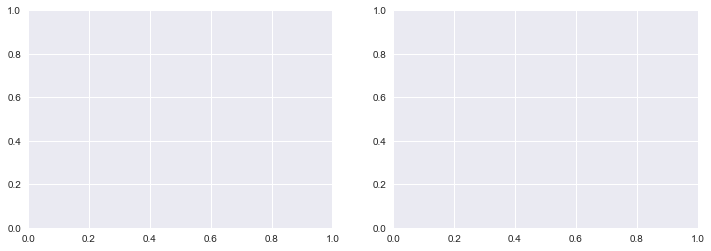

In [12]:
# Compute scalings
trees = Tree.objects.experiment.all()
stresses = []
print
print('Computing...', end='')
for i, tree in enumerate(trees):
    print(' #{}'.format(tree.id), end='')
    stresses.append(tree.scalings()[1])
tree_stresses = np.array([s.mean() for s in stresses])
flat_stresses = np.concatenate(stresses)

# Plot stresses
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
bins = axes[0].hist(tree_stresses, 20, label='Stress (pre-averaged on trees)')[1]
axes[0].set_ylabel('Number of trees')
axes[0].legend(loc='best')
axes[1].hist(flat_stresses, bins=20, label='Stress (for all depths)')
axes[1].set_ylabel('Number of (tree, depth)s')
axes[1].legend(loc='best');

Define the branch plotting function

In [13]:
def plot_branches(x, y, **kwargs):
    data = kwargs.pop('data')
    x_name = y_name = ''
    if isinstance(x, str):
        x_name = x
        x = data[x_name]
    if isinstance(y, str):
        y_name = y
        y = data[y_name]
    ax = kwargs.get('ax', plt.gca())
    
    # Get tree
    sentences = [Sentence.objects.get(id=id) for id in data['sentence id']]
    assert len(set(s.tree for s in sentences)) == 1
    tree = sentences[0].tree
    
    # Define colors
    branches = sorted(set(data['branch']), reverse=True)
    cmap, palette = mpl_palette(len(branches))
    
    # Plot branches
    legend_handles = []
    for i, branch in enumerate(branches):
        bdata = concat([DataFrame({'branch': branch, 'depth': 0, 'x': 0}, index=[-1]),
                        data[data.branch == branch]])
        bdata.plot(x_name, y_name, ax=ax, color=palette[i])
        legend_handles.append(Patch(color=palette[i], label='#{}'.format(branch)))
    
    # Set legend data (seaborn catches legend stuff if we do it here,
    # so we return some data by this mechanism and use it in the
    # plotting code after FacetGrid.map_dataframe()).
    legends = kwargs.get('legends', None)
    if legends is not None:
        legends[tree.id] = legend_handles
    
    # Set chrome
    if kwargs.get('set_chrome', False):
        ax.set_title('tree id = {}'.format(tree.id))
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)

Now plot scalings for all trees

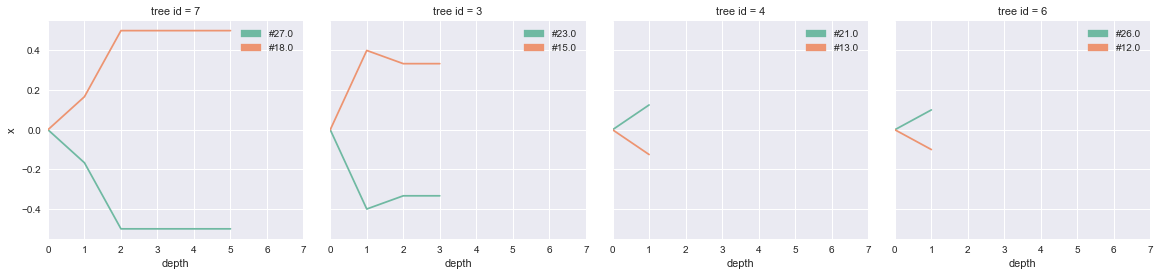

In [14]:
# Make a DataFrame of all trees
trees = Tree.objects.experiment
trees_order = root_order[root_order['tree id'].isin([tree.id for tree in trees])]['tree id']
tree_scalings = []
for tree in trees:
    s, _ = tree.scalings()
    s['tree id'] = tree.id
    tree_scalings.append(s)
tree_scalings = concat(tree_scalings)

# Plot and handle legend
g = sb.FacetGrid(tree_scalings, col='tree id',
                 sharex=True, sharey=True,
                 col_wrap=7, size=4,
                 col_order=trees_order)
legends = {}
g.map_dataframe(plot_branches, 'depth', 'x',
                set_chrome=True, legends=legends)
g.set(xlim=(0, tree_scalings['depth'].max() * 1.4))
for i, ax in enumerate(g.axes):
    ax.legend(handles=legends[trees_order.iloc[i]], loc='upper right')
if SAVE_FIGURES:
    g.savefig(FIG.format('branches_mds'), dpi=300)